# Broadway Sales Research Modeling

### Import and join datasets

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

weather = pd.read_pickle('data/processed/weather.pkl')
grosses = pd.read_pickle('data/processed/grosses.pkl')

In [4]:
weather = weather.rename(columns={"Week Ending":"Date"})
weather.head(2)

,Date,temperature_2m_mean,temperature_2m_min,temperature_2m_max,apparent_temperature_max,apparent_temperature_min,apparent_temperature_mean,precipitation_sum,precipitation_hours,daylight_duration,sunshine_duration,snowfall_sum,showers_sum,rain_sum
0,1996-03-24 04:00:00,3.571250,-1.6725,10.427501,6.503645,-6.534769,-0.805065,0.000000,0.0,44429.293000,40204.098000,0.000000,0.0,0.0
1,1996-03-31 04:00:00,3.867679,-4.5225,14.877501,12.330812,-8.964521,-0.075191,111.899993,23.0,45082.879857,34754.791714,109.199993,0.0,2.7


In [5]:
grosses.head(2)

,ShowID,Date,Attendance,% Capacity,# Previews,# Perf.,Gross ($),Month,Year,Adjusted Gross
0,&-juliet-534962,2024-05-26,7540,0.92,0,8,877626,5,2024,897398.313035
1,&-juliet-534962,2024-06-02,6824,0.83,0,8,775476,6,2024,792946.943458


In [6]:
# Make Date columns same type
grosses['Date'] = grosses['Date'].dt.date
weather['Date'] = weather['Date'].dt.date

In [7]:
# Merge DFs
df = pd.merge(grosses, weather, on='Date', how='inner')

In [8]:
df.head(2)

,ShowID,Date,Attendance,% Capacity,# Previews,# Perf.,Gross ($),Month,Year,Adjusted Gross,...,apparent_temperature_max,apparent_temperature_min,apparent_temperature_mean,precipitation_sum,precipitation_hours,daylight_duration,sunshine_duration,snowfall_sum,showers_sum,rain_sum
0,&-juliet-534962,2024-05-26,7540,0.92,0,8,877626,5,2024,897398.313035,...,30.266544,9.479221,20.403003,3.200000,6.0,52938.827571,45936.191143,0.0,0.0,3.200000
1,&-juliet-534962,2024-06-02,6824,0.83,0,8,775476,6,2024,792946.943458,...,27.329185,9.981629,18.406672,49.200001,26.0,53531.232857,42437.518571,0.0,0.0,49.200001


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25991 entries, 0 to 25990
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ShowID                     25991 non-null  object 
 1   Date                       25991 non-null  object 
 2   Attendance                 25991 non-null  int64  
 3   % Capacity                 25991 non-null  float64
 4   # Previews                 25991 non-null  int64  
 5   # Perf.                    25991 non-null  int64  
 6   Gross ($)                  25991 non-null  int64  
 7   Month                      25991 non-null  int32  
 8   Year                       25991 non-null  int32  
 9   Adjusted Gross             25991 non-null  float64
 10  temperature_2m_mean        25991 non-null  float64
 11  temperature_2m_min         25991 non-null  float64
 12  temperature_2m_max         25991 non-null  float64
 13  apparent_temperature_max   25991 non-null  flo

<ul>
    <li>
        Need to change Date column back to datetime format
    </li>
    <li>
        Need to engineer features to improve model performance:
        <ul><li>Create dummy variables for month</li>
            <li>Normalize/Standardize variables such as daylight duration or sunshine duration</li>
            <li>Remove redundant variables such as unadjusted gross to remove collinearity
    </li>

### Data Cleaning

In [12]:
# Checking for missing values
df.isnull().any()

ShowID                       False
Date                         False
Attendance                   False
% Capacity                   False
# Previews                   False
# Perf.                      False
Gross ($)                    False
Month                        False
Year                         False
Adjusted Gross               False
temperature_2m_mean          False
temperature_2m_min           False
temperature_2m_max           False
apparent_temperature_max     False
apparent_temperature_min     False
apparent_temperature_mean    False
precipitation_sum            False
precipitation_hours          False
daylight_duration            False
sunshine_duration            False
snowfall_sum                 False
showers_sum                  False
rain_sum                     False
dtype: bool

No missing values

In [14]:
# Converting date column back to datetime type
df['Date'] = pd.to_datetime(df['Date'])

In [15]:
# Account for duplicate rows
df = df.drop_duplicates()

In [16]:
# Drop irrelevant columns
df = df.drop(['Gross ($)', 'precipitation_sum', 'showers_sum'], axis = 1)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25991 entries, 0 to 25990
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   ShowID                     25991 non-null  object        
 1   Date                       25991 non-null  datetime64[ns]
 2   Attendance                 25991 non-null  int64         
 3   % Capacity                 25991 non-null  float64       
 4   # Previews                 25991 non-null  int64         
 5   # Perf.                    25991 non-null  int64         
 6   Month                      25991 non-null  int32         
 7   Year                       25991 non-null  int32         
 8   Adjusted Gross             25991 non-null  float64       
 9   temperature_2m_mean        25991 non-null  float64       
 10  temperature_2m_min         25991 non-null  float64       
 11  temperature_2m_max         25991 non-null  float64       
 12  appa

### Exploratory Data Analysis

<b>Univariate Analysis</b>

<Axes: xlabel='Adjusted Gross', ylabel='Count'>

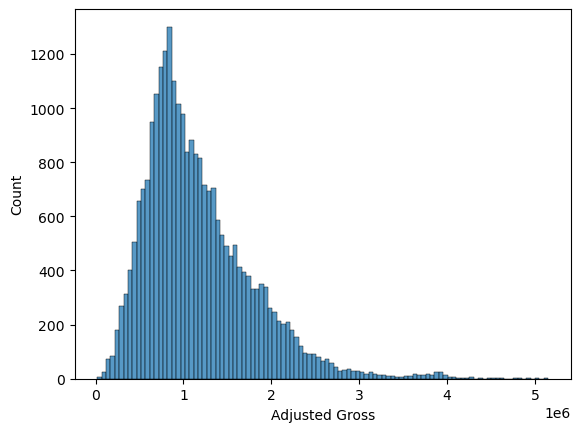

In [32]:
# Analyzing Grosses
sns.histplot(x=df['Adjusted Gross'])

<ul><li>Grosses are right skewed centered around a mean of roughly $900k</li>
<li>Most shows gross between 500k to 1.5M</li>

<Axes: xlabel='temperature_2m_min'>

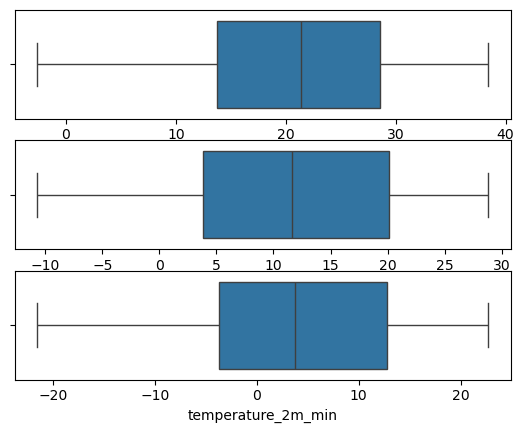

In [34]:
# Analyzing Temperature
fig, axs = plt.subplots(nrows=3)

sns.boxplot(x=df['temperature_2m_max'], ax=axs[0])
sns.boxplot(x=df['temperature_2m_mean'], ax=axs[1])
sns.boxplot(x=df['temperature_2m_min'], ax=axs[2])

<Axes: xlabel='Attendance', ylabel='Count'>

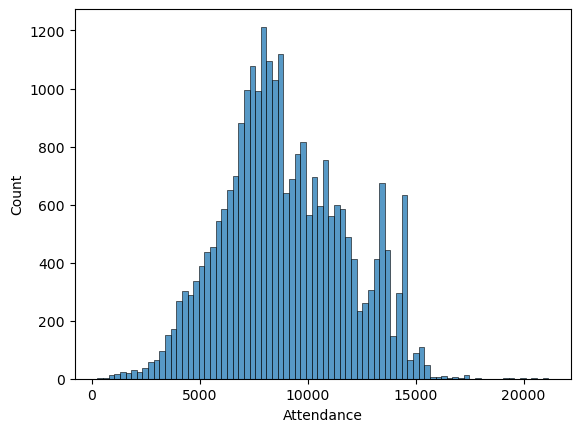

In [35]:
# Analyzing Attendance
sns.histplot(x=df['Attendance'])

Relatively normally distributed, peak around higher end because of popular shows

<b>Bivariate Analysis</b>

<Axes: >

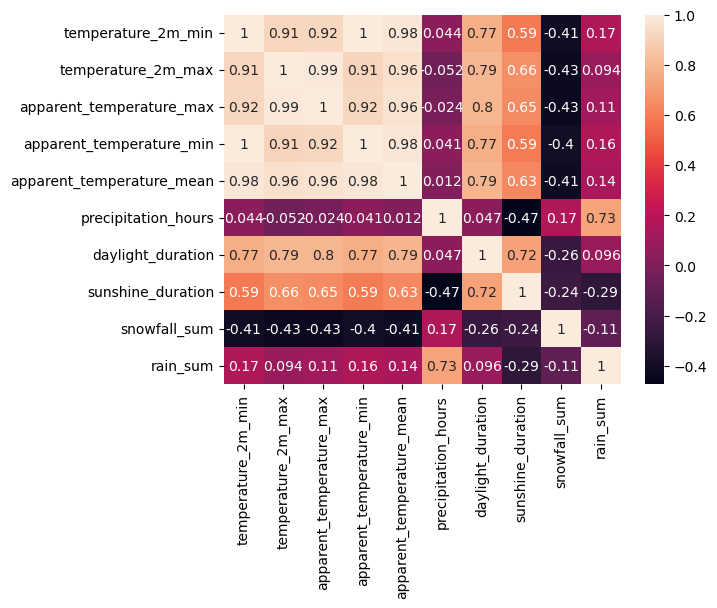

In [39]:
# Correlation Heatmap - check multicollinearity between weather regressor variables

sns.heatmap(df.iloc[:, 10:22].corr(), annot=True)

<u>Inferences:</u>
<ul>
    <li>Apparent and actual weather variable are highly correlated and could cause multicollinearity - should use one of these sets (actual weather) </li>
    <li>High correlation between sunshine and daylight duration variables, as well as daylight duration with other temperature variables (0.72-0.8). To address multicollinearity, can combine sunshine and daylight duration into a sunlight_ratio field, also making it more meaningful inference, which describes "what % of daylight was actually sunny?"</li>
    <li>High correlation between precipitation_hours and rain_sum, likely as there is a high probability that the longer rain occurs, the higher the sum of total precipitation. To address this multicollinearity, we can drop one of the fields - likely precipitation_hours, as we dont need to test for both intensity of rain and presence, and rain_sum is sufficient to describe a presence of rain with a moderate interpretation of intensity</li>
</ul>

<Axes: xlabel='Date'>

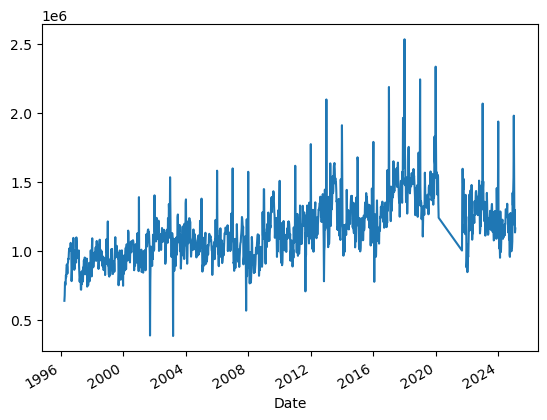

In [42]:
# Line plot: view yearly vs monthly seasonal trends in grosses
df.groupby("Date")["Adjusted Gross"].mean().plot()

Yearly peaks in adjusted grosses, agnostic of show type. Can examine a couple random years to see effect more clearly.

<Axes: xlabel='Month', ylabel='Adjusted Gross'>

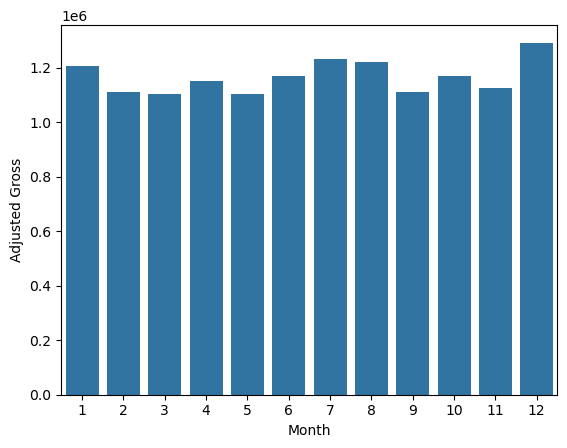

In [46]:
# Separating grosses by month to test the hypothesis of month-by-month seasonality in sales
sns.barplot(df.groupby("Month")["Adjusted Gross"].mean())

Dec/Jan as well as summer months are peaks - makes sense to make monthly dummies

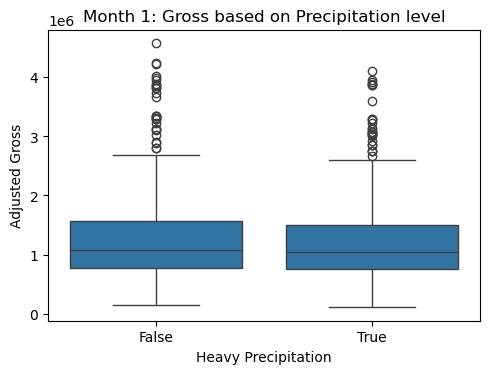

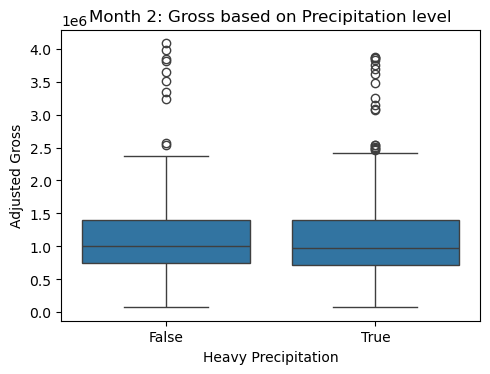

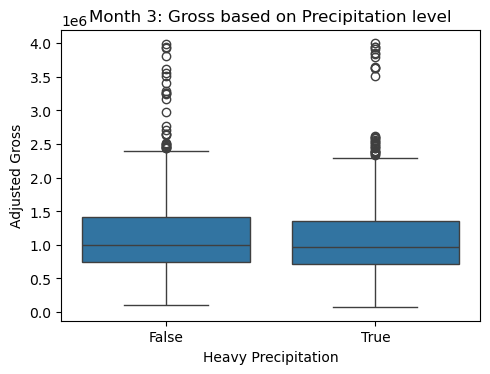

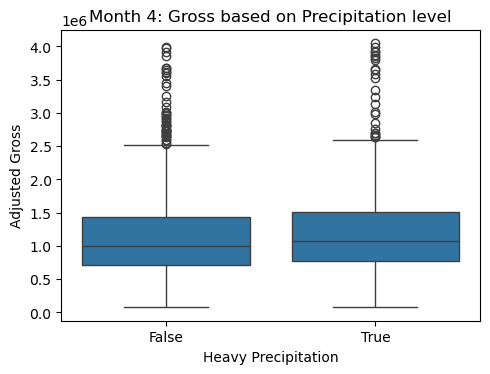

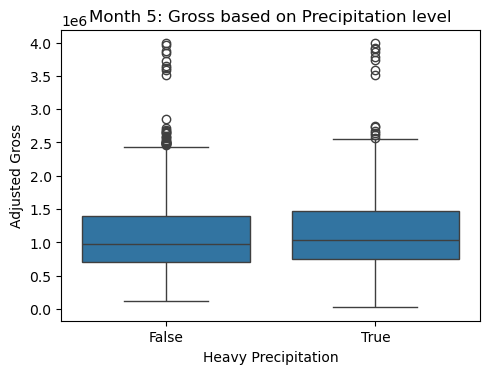

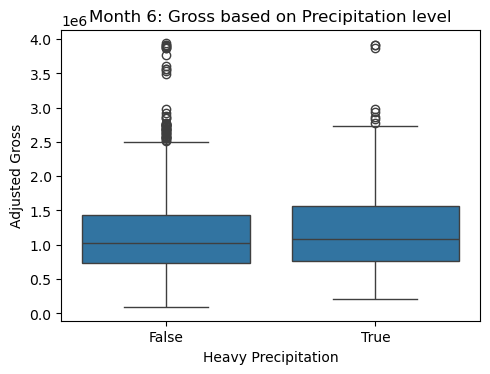

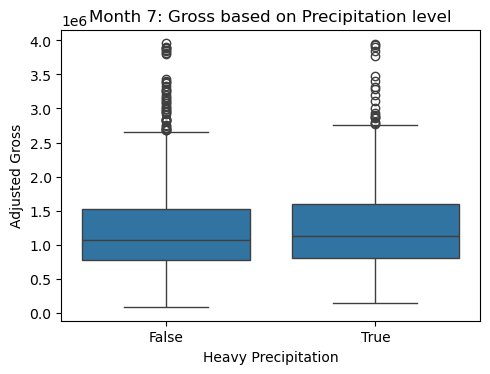

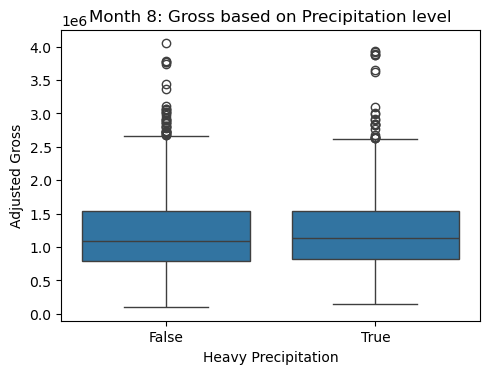

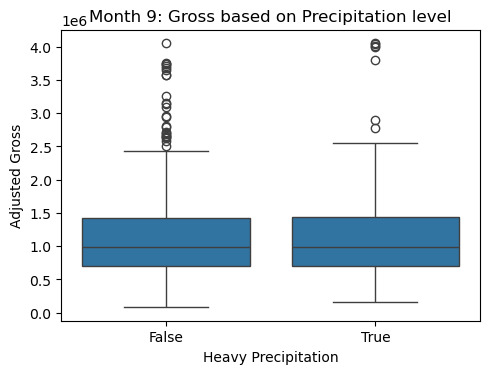

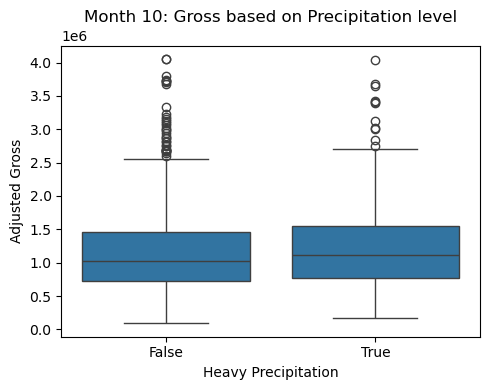

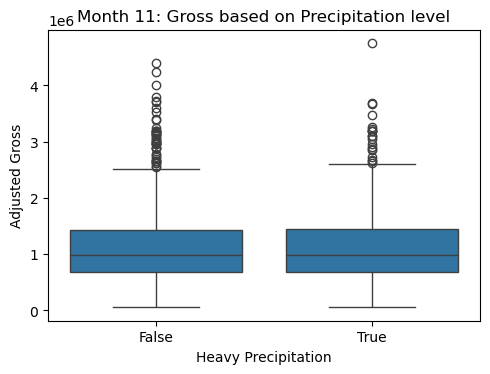

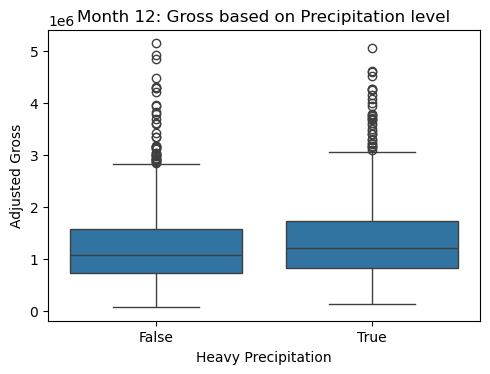

In [78]:
# Evaluate Grosses Distribution by heavy or not heavy precipitation
df['HeavyPrecipitation'] = (df['rain_sum'] + df['snowfall_sum']) > 30

for i in range(1,13):
    plt.figure(figsize=(5, 4))
    sns.boxplot(
    data=df[df['Month'] == i],
    x='HeavyPrecipitation',
    y='Adjusted Gross'
    )
    plt.title(f'Month {i}: Gross based on Precipitation level')
    plt.xlabel('Heavy Precipitation')
    plt.ylabel('Adjusted Gross')
    plt.tight_layout()
    plt.show()

No visible difference between grosses with heavy or light precipitation weeks

<Axes: xlabel='snowfall_sum', ylabel='Adjusted Gross'>

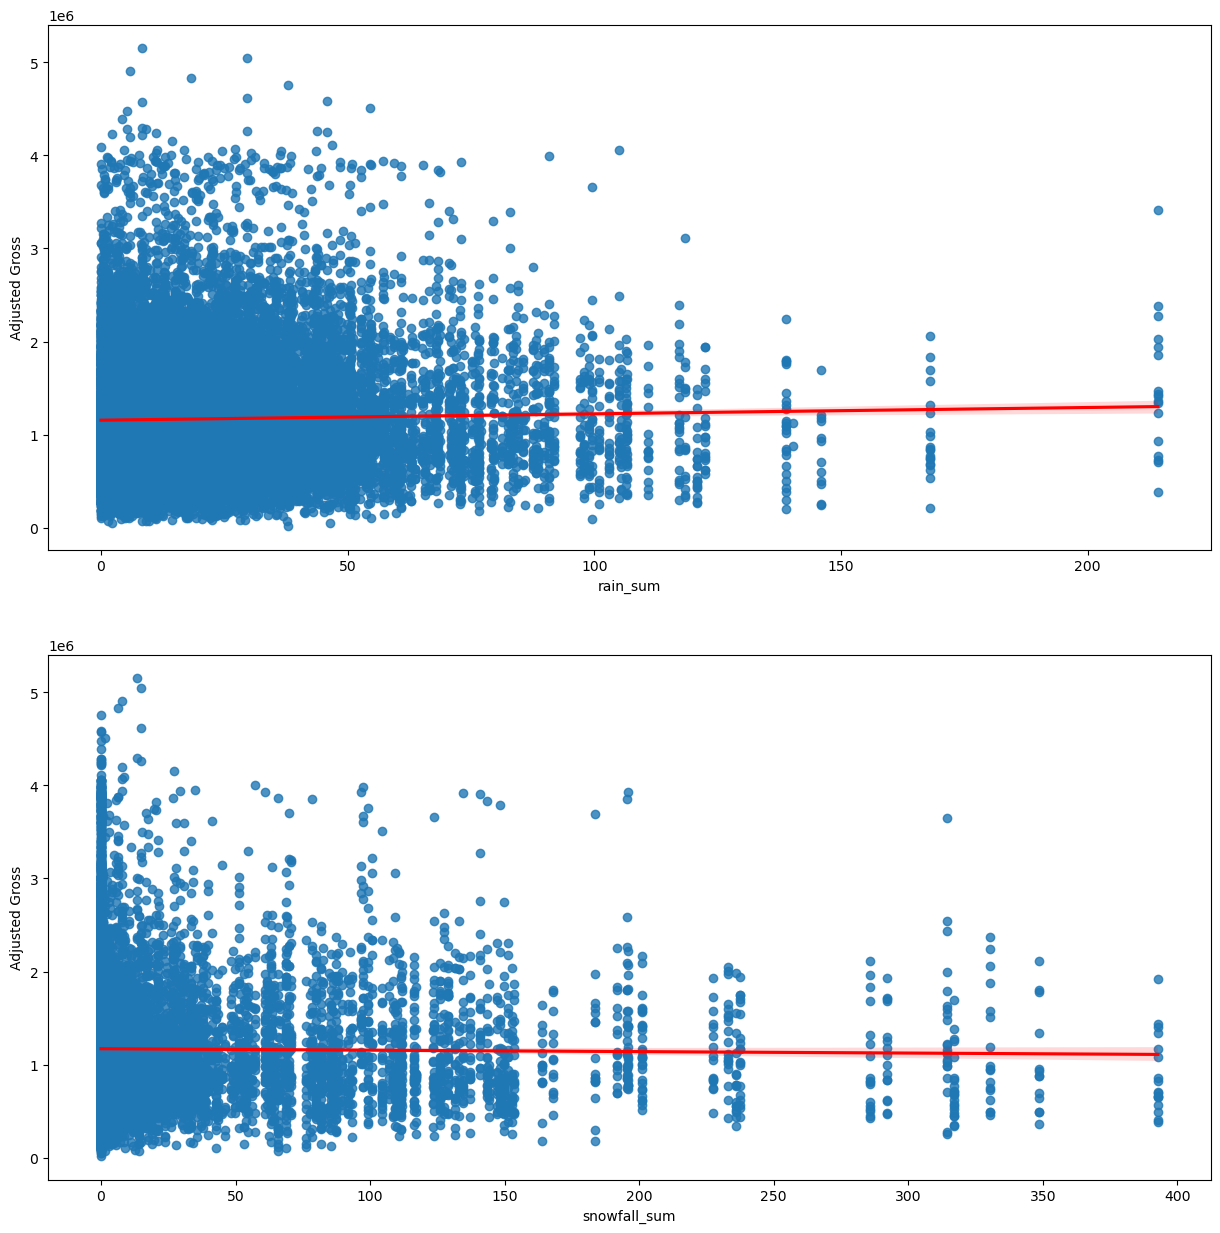

In [95]:
# Scatterplot Rain, Snow vs Adjusted Grosses

f, axes = plt.subplots(2,1, figsize=(15,15))
sns.regplot(data=df, x=df['rain_sum'], y=df['Adjusted Gross'], line_kws=dict(color="r"), ax=axes[0])
sns.regplot(data=df, x=df['snowfall_sum'], y=df['Adjusted Gross'], line_kws=dict(color="r"), ax=axes[1])

### Feature Engineering

In [100]:
# Revisit Columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25991 entries, 0 to 25990
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   ShowID                     25991 non-null  object        
 1   Date                       25991 non-null  datetime64[ns]
 2   Attendance                 25991 non-null  int64         
 3   % Capacity                 25991 non-null  float64       
 4   # Previews                 25991 non-null  int64         
 5   # Perf.                    25991 non-null  int64         
 6   Month                      25991 non-null  int32         
 7   Year                       25991 non-null  int32         
 8   Adjusted Gross             25991 non-null  float64       
 9   temperature_2m_mean        25991 non-null  float64       
 10  temperature_2m_min         25991 non-null  float64       
 11  temperature_2m_max         25991 non-null  float64       
 12  appa

In [102]:
# Create Sunlight Ratio column
df['Sunlight Ratio'] = df['sunshine_duration'] / df['daylight_duration']

In [106]:
# Create Monthly dummies
month_dummies = pd.get_dummies(df['Month'], prefix='Month')
df = pd.concat([df, month_dummies], axis=1)

In [108]:
df = df.drop(columns=['Month', 'temperature_2m_min', 'temperature_2m_max', 'apparent_temperature_min', 'apparent_temperature_max', 'precipitation_hours', 'daylight_duration', 'sunshine_duration'])

In [114]:
# Updated columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25991 entries, 0 to 25990
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   ShowID                     25991 non-null  object        
 1   Date                       25991 non-null  datetime64[ns]
 2   Attendance                 25991 non-null  int64         
 3   % Capacity                 25991 non-null  float64       
 4   # Previews                 25991 non-null  int64         
 5   # Perf.                    25991 non-null  int64         
 6   Year                       25991 non-null  int32         
 7   Adjusted Gross             25991 non-null  float64       
 8   temperature_2m_mean        25991 non-null  float64       
 9   apparent_temperature_mean  25991 non-null  float64       
 10  snowfall_sum               25991 non-null  float64       
 11  rain_sum                   25991 non-null  float64       
 12  Heav